In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parallel import DataParallel
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
def generate_tvar_sample(p, T=600, W=40, P0=0.5, sigma_noise=0.1, burnin=300, max_attempts=100):
    """Generate one TVAR(p) sample with power constraint and burnin.
    
    Args:
        p (int): Order of the TVAR model.
        T (int): Length of the desired output time series.
        W (int): Window size for power constraint.
        P0 (float): Maximum allowed power in any window of size W.
        sigma_noise (float): Standard deviation of the Gaussian noise.
        burnin (int): Number of initial samples to discard.
        max_attempts (int): Maximum number of attempts to generate a valid sample.
    """
    
    T_total = T + burnin
    
    # Coefficient functions - scaled for stability
    base_freqs = [1/150, 1/200, 1/180, 1/220, 1/170, 1/190]
    base_amps = [0.35, 0.25, 0.20, 0.15, 0.12, 0.10]
    base_offsets = [0.6, -0.5, 0.3, -0.2, 0.15, -0.1]
    scale = 1.0 / np.sqrt(p)
    
    for attempt in range(max_attempts):
        # Generate coefficients
        coeffs_full = np.zeros((T_total, p))
        for k in range(p):
            freq = base_freqs[k % 6]
            amp = base_amps[k % 6] * scale
            offset = base_offsets[k % 6] * scale
            phase = k * np.pi / 4
            t_arr = np.arange(T_total)
            if k % 2 == 0:
                coeffs_full[:, k] = offset + amp * np.sin(2 * np.pi * freq * t_arr + phase)
            else:
                coeffs_full[:, k] = offset + amp * np.cos(2 * np.pi * freq * t_arr + phase)
        
        # Simulate signal
        x_full = np.zeros(T_total)
        for i in range(T_total):
            val = np.random.normal(scale=sigma_noise)
            for k in range(p):
                if i > k:
                    val += coeffs_full[i, k] * x_full[i - k - 1]
            x_full[i] = val
            
            if i >= W - 1:
                window = x_full[i - W + 1:i + 1]
                current_power = np.mean(window ** 2)
                if current_power > 0:
                    s = np.clip(np.sqrt(P0 / current_power), 0.8, 1.2)
                    x_full[i] *= s
        
        # Discard burnin
        x = x_full[burnin:]
        coeffs = coeffs_full[burnin:]
        
        # Check power constraint (same logic as original)
        power = np.zeros(T)
        for i in range(T):
            start = max(0, i - W + 1)
            power[i] = np.mean(x[start:i + 1] ** 2)
        
        if power.max() <= P0:
            return x, coeffs
    
    raise ValueError(f"Failed to generate valid sample after {max_attempts} attempts")

def generate_dataset(n_samples, p_min=2, p_max=6, T=600):
    X = np.zeros((n_samples, T))
    coeffs_all = np.zeros((n_samples, T, p_max))
    p_true = np.zeros(n_samples, dtype=np.int64)
    
    for i in tqdm(range(n_samples)):
        p = np.random.randint(p_min, p_max + 1)
        x, coeffs = generate_tvar_sample(p, T=T)
        X[i] = x
        coeffs_all[i, :, :p] = coeffs
        p_true[i] = p - p_min  # 0-indexed for cross entropy
    
    return X, coeffs_all, p_true

In [3]:
def plot_tvar_sample(x, coeffs, p, W=40, P0=0.5):
    T = len(x)
    
    # Compute sliding window power
    power = np.zeros(T)
    for i in range(T):
        start = max(0, i - W + 1)
        power[i] = np.mean(x[start:i + 1] ** 2)
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    
    # Coefficients
    for k in range(p):
        axes[0].plot(coeffs[:, k], label=f'a{k+1}')
    axes[0].set_ylabel('Coefficients')
    axes[0].legend(loc='upper right')
    
    # Signal
    axes[1].plot(x)
    axes[1].set_ylabel('Amplitude')
    
    # Power
    axes[2].plot(power, color='tab:orange')
    axes[2].axhline(P0, color='k', linestyle='--')
    axes[2].set_ylabel('Power')
    axes[2].set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()

In [4]:
example_sample = generate_tvar_sample(p=6)
example_sample[0].shape, example_sample[1].shape

((600,), (600, 6))

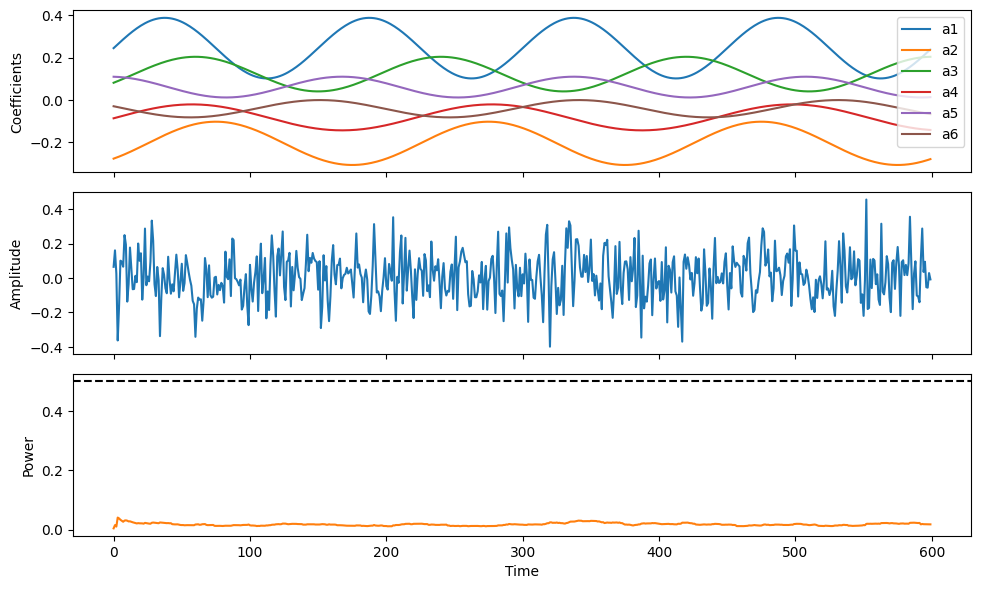

In [5]:
plot_tvar_sample(example_sample[0], example_sample[1], p=6)

In [ ]:
class TVARNet(nn.Module):
    def __init__(self, seq_len=600, p_max=6, hidden_dim=128):
        super().__init__()
        self.seq_len = seq_len
        self.p_max = p_max
        
        # P-Block: predicts order
        self.p_block = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, p_max)
        )
        
        # D-Block: (N, seq_len + p_max) -> (N, seq_len * p_max)
        self.d_block = nn.Sequential(
            nn.Linear(seq_len + p_max, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, seq_len * p_max)
        )
    
    def forward(self, x, temperature=1.0):
        # x: (N, seq_len)
        N = x.shape[0]
        
        # P-Block
        p_logits = self.p_block(x)  # (N, p_max)
        p_soft = F.gumbel_softmax(p_logits, tau=temperature, hard=True)  # (N, p_max)
        p_hard = torch.argmax(p_soft, dim=-1)  # (N,)
        
        # Cumulative mask
        indices = torch.arange(self.p_max, device=x.device).unsqueeze(0)  # (1, p_max)
        mask = (indices <= p_hard.unsqueeze(1) + 1).float()  # (N, p_max)
        
        # D-Block: concat x and p_soft
        d_input = torch.cat([x, p_soft], dim=1)  # (N, seq_len + p_max)
        coeffs_raw = self.d_block(d_input)  # (N, seq_len * p_max)
        coeffs_raw = coeffs_raw.view(N, self.seq_len, self.p_max)  # (N, seq_len, p_max)
        
        # Apply mask
        coeffs = coeffs_raw * mask.unsqueeze(1)  # (N, seq_len, p_max)
        
        # Vectorized AR: build lag matrix and do batch matmul
        # x_lagged[:, t, k] = x[:, t - k - 1]
        x_lagged = torch.zeros(N, self.seq_len, self.p_max, device=x.device)
        for k in range(self.p_max):
            x_lagged[:, k+1:, k] = x[:, :self.seq_len - k - 1]
        
        # x_hat[n, t] = sum_k coeffs[n, t, k] * x_lagged[n, t, k]
        x_hat = (coeffs * x_lagged).sum(dim=-1)  # (N, seq_len)
        
        return coeffs, p_logits, p_hard, x_hat


In [7]:
def loss_p(p_logits, p_true):
    return F.cross_entropy(p_logits, p_true)


def loss_ar(x, x_hat, p_max):
    return F.mse_loss(x_hat[:, p_max:], x[:, p_max:])


# def loss_energy(x_hat, P0=0.5, W=40):
#     N, T = x_hat.shape
#     powers = []
#     for i in range(T):
#         start = max(0, i - W + 1)
#         window = x_hat[:, start:i+1]
#         powers.append((window ** 2).mean(dim=1))
#     powers = torch.stack(powers, dim=1)
#     return ((powers - P0) ** 2).mean()

def loss_energy(x_hat, P0=0.5, W=40):
    # Use unfold for sliding window
    N, T = x_hat.shape
    # Pad at start so we get T windows
    x_padded = F.pad(x_hat, (W - 1, 0), mode='constant', value=0)
    windows = x_padded.unfold(1, W, 1)  # (N, T, W)
    powers = (windows ** 2).mean(dim=-1)  # (N, T)
    return ((powers - P0) ** 2).mean()


def loss_smooth(coeffs):
    diff = coeffs[:, 1:, :] - coeffs[:, :-1, :]
    return torch.mean(torch.sum(diff ** 2, dim=2))

In [8]:
# Generate data
# X_train, coef_train, p_train = generate_dataset(10000, p_min=2, p_max=6)
# X_val, coef_val, p_val = generate_dataset(1000, p_min=2, p_max=6)

# np.savez_compressed('model/tvar_dataset.npz',
#                     X_train=X_train, coef_train=coef_train, p_train=p_train,
#                     X_val=X_val, coef_val=coef_val, p_val=p_val)

d = np.load('model/tvar_dataset.npz')
X_train, coef_train, \
    p_train, X_val, coef_val, p_val = [d[k][:500] for k in ['X_train', 'coef_train', 
                                                      'p_train', 'X_val', 'coef_val', 'p_val']]
d.close()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.init()
print(f"Using device: {device}")

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

# Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
model = TVARNet(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
# model = DataParallel(model)
model = model.to(device)

Using device: cuda


In [10]:
summary(model, input_size=(32, 600), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
TVARNet                                  [32, 600, 5]              --
├─Sequential: 1-1                        [32, 5]                   --
│    └─Linear: 2-1                       [32, 128]                 76,928
│    └─Tanh: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 128]                 16,512
│    └─Tanh: 2-4                         [32, 128]                 --
│    └─Linear: 2-5                       [32, 5]                   645
├─Sequential: 1-2                        [32, 3000]                --
│    └─Linear: 2-6                       [32, 128]                 77,568
│    └─Tanh: 2-7                         [32, 128]                 --
│    └─Linear: 2-8                       [32, 128]                 16,512
│    └─Tanh: 2-9                         [32, 128]                 --
│    └─Linear: 2-10                      [32, 3000]                3

In [11]:
def train(
    model,
    train_loader,
    val_loader,
    n_epochs=100,
    lr=1e-3,
    lambda_p=10.0,
    lambda_ar=1.0,
    lambda_energy=0.1,
    lambda_smooth=0.05,
    P0=0.5,
    W=40,
    p_max=6,
    device='cuda'
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    history = {
        'train_loss': [], 'train_p': [], 'train_ar': [], 'train_energy': [], 'train_smooth': [], 'train_p_acc': [],
        'val_loss': [], 'val_p': [], 'val_ar': [], 'val_energy': [], 'val_smooth': [], 'val_p_acc': []
    }
    
    pbar = tqdm(total=n_epochs, desc='Training')
    for epoch in range(n_epochs):
        # Train
        model.train()
        train_losses = {'total': [], 'p': [], 'ar': [], 'energy': [], 'smooth': []}
        train_correct = 0
        train_total = 0
        
        for x_batch, p_batch in train_loader:
            x_batch = x_batch.to(device)
            p_batch = p_batch.to(device)
            
            optimizer.zero_grad()
            
            coeffs, p_logits, p_hard, x_hat = model(x_batch)
            
            l_p = loss_p(p_logits, p_batch)
            l_ar = loss_ar(x_batch, x_hat, p_max)
            l_energy = loss_energy(x_hat, P0, W)
            l_smooth = loss_smooth(coeffs)
            
            total_loss = lambda_p * l_p + lambda_ar * l_ar + lambda_energy * l_energy + lambda_smooth * l_smooth
            
            total_loss.backward()
            optimizer.step()
            
            train_losses['total'].append(total_loss.item())
            train_losses['p'].append(l_p.item())
            train_losses['ar'].append(l_ar.item())
            train_losses['energy'].append(l_energy.item())
            train_losses['smooth'].append(l_smooth.item())
            
            train_correct += (p_hard == p_batch).sum().item()
            train_total += p_batch.shape[0]
        
        # Validate
        model.eval()
        val_losses = {'total': [], 'p': [], 'ar': [], 'energy': [], 'smooth': []}
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for x_batch, p_batch in val_loader:
                x_batch = x_batch.to(device)
                p_batch = p_batch.to(device)
                
                coeffs, p_logits, p_hard, x_hat = model(x_batch)
                
                l_p = loss_p(p_logits, p_batch)
                l_ar = loss_ar(x_batch, x_hat, p_max)
                l_energy = loss_energy(x_hat, P0, W)
                l_smooth = loss_smooth(coeffs)
                
                total_loss = lambda_p * l_p + lambda_ar * l_ar + lambda_energy * l_energy + lambda_smooth * l_smooth
                
                val_losses['total'].append(total_loss.item())
                val_losses['p'].append(l_p.item())
                val_losses['ar'].append(l_ar.item())
                val_losses['energy'].append(l_energy.item())
                val_losses['smooth'].append(l_smooth.item())
                
                val_correct += (p_hard == p_batch).sum().item()
                val_total += p_batch.shape[0]
        
        history['train_loss'].append(np.mean(train_losses['total']))
        history['train_p'].append(np.mean(train_losses['p']))
        history['train_ar'].append(np.mean(train_losses['ar']))
        history['train_energy'].append(np.mean(train_losses['energy']))
        history['train_smooth'].append(np.mean(train_losses['smooth']))
        history['train_p_acc'].append(train_correct / train_total)
        
        history['val_loss'].append(np.mean(val_losses['total']))
        history['val_p'].append(np.mean(val_losses['p']))
        history['val_ar'].append(np.mean(val_losses['ar']))
        history['val_energy'].append(np.mean(val_losses['energy']))
        history['val_smooth'].append(np.mean(val_losses['smooth']))
        history['val_p_acc'].append(val_correct / val_total)
        
        scheduler.step(history['val_loss'][-1])
        
        
        pbar.update(1)
        pbar.set_postfix(
            train=f"{history['train_loss'][-1]:.4f}",
            val=f"{history['val_loss'][-1]:.4f}",
            p_acc=f"{history['val_p_acc'][-1]:.3f}"
        )
    
    pbar.close()
    return history

In [ ]:
# hyperparameters
n_epochs = 500
lr = 1e-3
lambda_p = 100.0
lambda_ar = 1.0
lambda_energy = 0.1
lambda_smooth = 5
max_ar_order = 6  # max AR order for skipping initial samples in loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train
history = train(
    model, train_loader, val_loader,
    n_epochs=n_epochs, lr=lr,
    lambda_p=lambda_p, lambda_ar=lambda_ar, lambda_energy=lambda_energy, lambda_smooth=lambda_smooth,
    p_max=max_ar_order, device=device
)

Training: 100%|██████████| 500/500 [00:18<00:00, 26.34it/s, p_acc=0.226, train=0.3556, val=536.9303]


In [18]:
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history
}, 'model/tvar_model.pt')

# Load
# checkpoint = torch.load('model/tvar_model.pt', weights_only=False)
# model.load_state_dict(checkpoint['model_state_dict'])
# history = checkpoint['history']

In [19]:
def plot_confusion_matrix(model, val_loader, device, p_min=2, p_max=6, ax=None):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    model.eval()
    all_p_pred = []
    all_p_true = []
    
    with torch.no_grad():
        for x_batch, p_batch in val_loader:
            x_batch = x_batch.to(device)
            _, _, p_hard, _ = model(x_batch)
            all_p_pred.extend(p_hard.cpu().numpy())
            all_p_true.extend(p_batch.numpy())
    
    n_classes = p_max - p_min + 1  # 5 classes for p=2,3,4,5,6
    cm = confusion_matrix(all_p_true, all_p_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[f'p={i+p_min}' for i in range(n_classes)])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    if ax:
        ax.set_title('P Confusion Matrix')
    return cm

def plot_history(history, model=None, val_loader=None, device=None, p_min=2, p_max=6):
    fig, axes = plt.subplots(2, 6, figsize=(20, 8))
    
    metrics = ['loss', 'p', 'ar', 'energy', 'smooth', 'p_acc']
    titles = ['Total Loss', 'P Loss (CE)', 'AR Loss', 'Energy Loss', 'Smooth Loss', 'P Accuracy']
    
    # Train metrics (row 0)     
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        axes[0, i].plot(history[f'train_{metric}'])
        axes[0, i].set_title(f'Train {title}')
        axes[0, i].set_xlabel('Epoch')
    
    # Val metrics (row 1, first 5)
    for i, (metric, title) in enumerate(zip(metrics[:5], titles[:5])):
        axes[1, i].plot(history[f'val_{metric}'])
        axes[1, i].set_title(f'Val {title}')
        axes[1, i].set_xlabel('Epoch')
    
    # Confusion matrix (row 1, last col)
    if model is not None and val_loader is not None and device is not None:
        plot_confusion_matrix(model, val_loader, device, p_min=p_min, p_max=p_max, ax=axes[1, 5])
    else:
        axes[1, 5].plot(history['val_p_acc'])
        axes[1, 5].set_title('Val P Accuracy')
        axes[1, 5].set_xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()

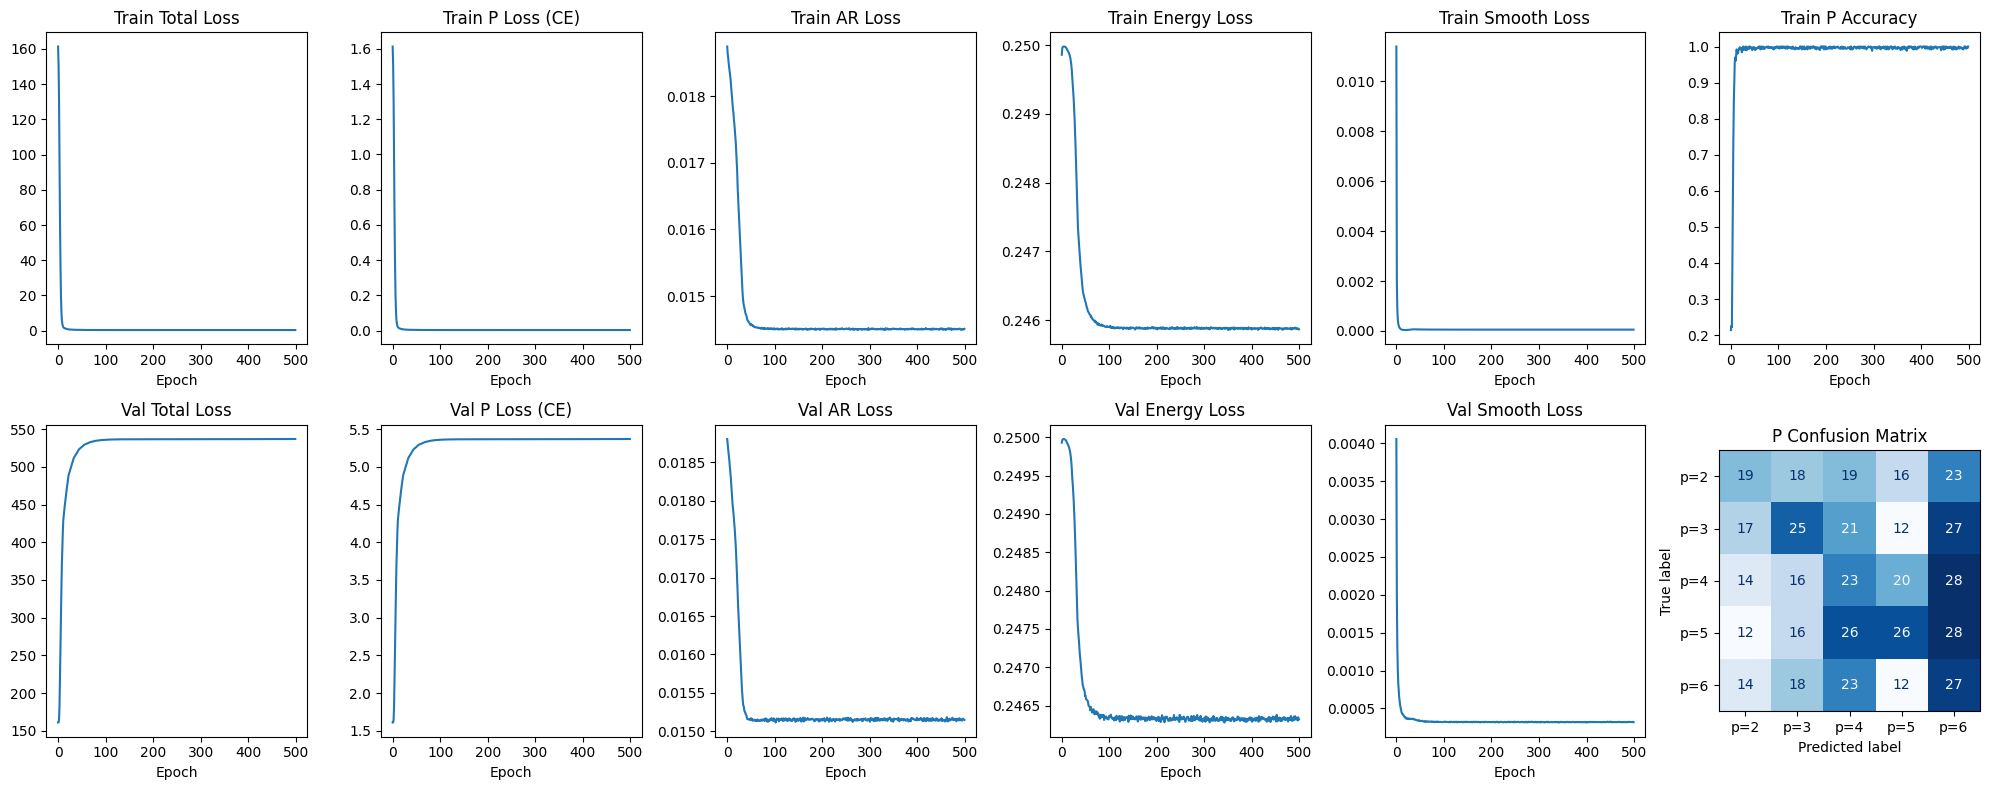

In [23]:
plot_history(history, model=model, val_loader=val_loader, device=device)

In [24]:
def plot_coefficients_by_p(model, X, coeffs_true, p_true, device, p_max=6, p_min=2, title=""):
    model.eval()
    
    n_classes = p_max - p_min + 1  # 5 classes for p=2,3,4,5,6
    fig, axes = plt.subplots(1, n_classes, figsize=(4 * n_classes, 4))
    
    with torch.no_grad():
        for p_idx in range(n_classes):
            ax = axes[p_idx]
            p_actual = p_idx + p_min  # AR order: 2,3,4,5,6
            n_coeffs = p_actual       # number of coefficients to plot
            
            mask = (p_true == p_idx).numpy() if torch.is_tensor(p_true) else (p_true == p_idx)
            if not mask.any():
                ax.set_title(f'p={p_actual} (no example)')
                continue
            
            idx = np.where(mask)[0][0]
            
            if torch.is_tensor(X):
                x = X[idx:idx+1].clone().detach().to(device)
            else:
                x = torch.from_numpy(X[idx:idx+1]).float().to(device)
            
            coeffs_pred, _, p_hard, _ = model(x)
            coeffs_pred = coeffs_pred.cpu().numpy()[0]  # (600, p_max)
            
            for k in range(n_coeffs):
                label_true = 'True' if k == 0 else None
                label_pred = 'Pred' if k == 0 else None
                ax.plot(coeffs_true[idx, :, k], 'k-', label=label_true)
                ax.plot(coeffs_pred[:, k], color='darkred', label=label_pred)
            
            ax.set_title(f'p={p_actual} (pred={p_hard.item() + p_min})')
            ax.set_xlabel('Time')
            ax.set_ylabel('Coefficient')
            ax.legend()
    
    plt.suptitle(title)
    
    plt.tight_layout()
    plt.show()

IndexError: index 5 is out of bounds for axis 1 with size 5

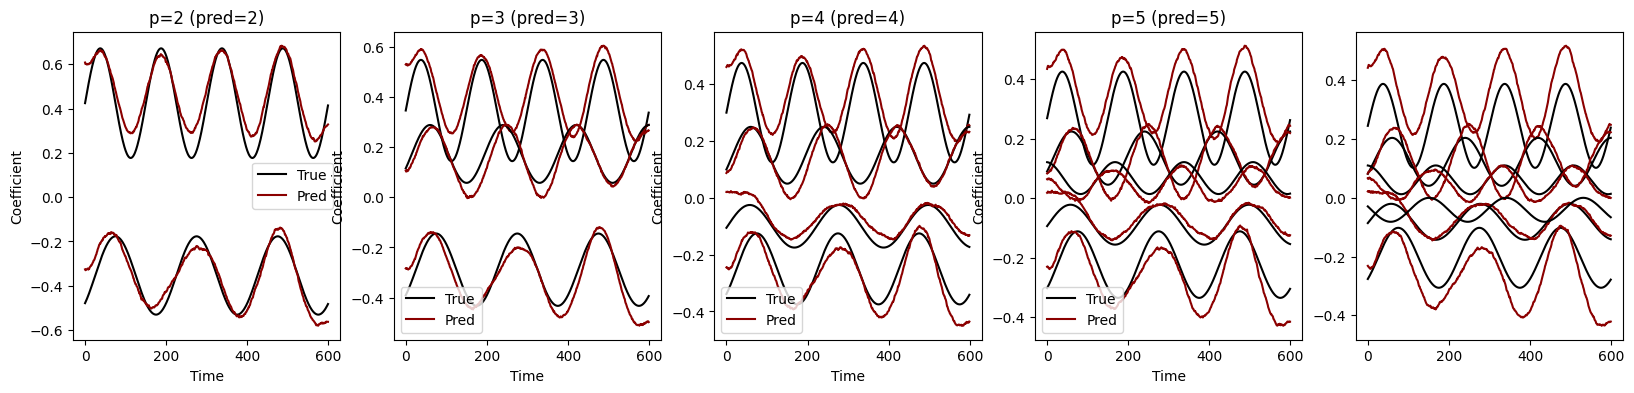

In [25]:
plot_coefficients_by_p(model, X_train, coef_train, p_train, device, title="Train Phi and P predictions")

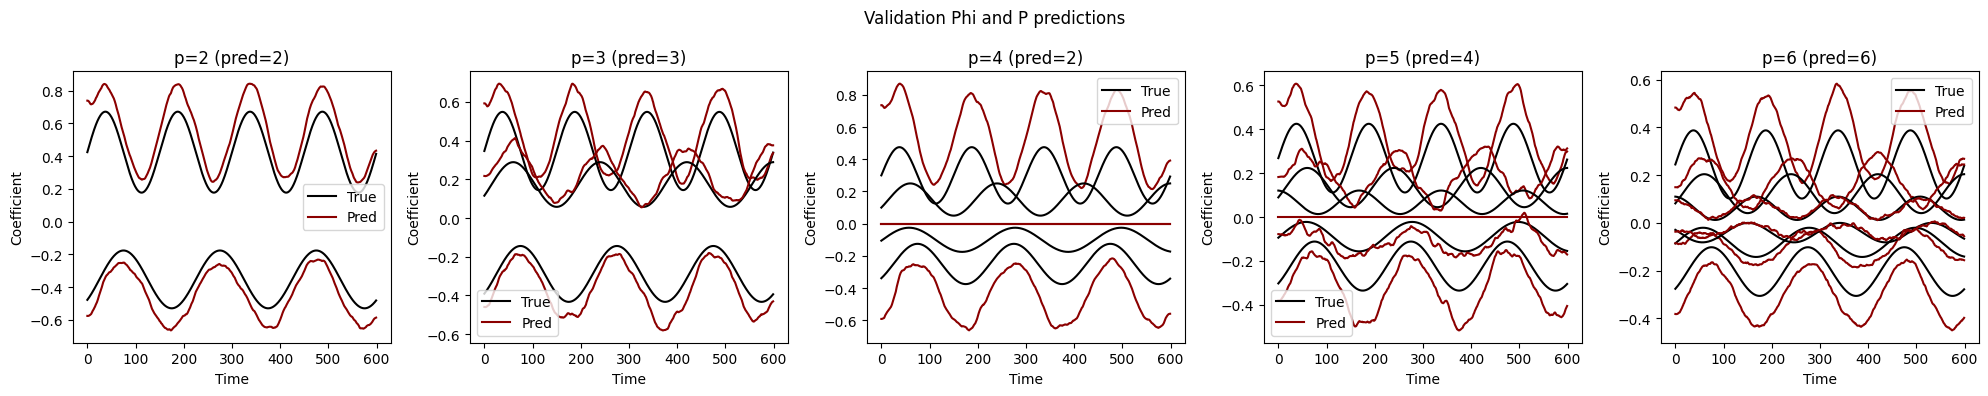

In [ ]:

plot_coefficients_by_p(model, X_val, coef_val, p_val, device, title="Validation Phi and P predictions")